In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

from unet_model import UNet
from seep_dataset import SeepImageDataset
from utils import ImageHelperFunctions, ImageTransformFunctions

In [2]:
IMAGE_DIR = "./seep_detection/images_256/"
MASK_DIR = "./seep_detection/masks_256/"

NUM_CLASSES = 8
NUM_CHANNELS = 1
BATCH_SIZE = 8
N_EPOCHS = 2000
LR = 1e-2
PATIENCE = 300
class_weights = [1, 20, 40, 40, 40, 20, 20, 80]

TRAIN = True
SUMMARY_WRITER_NAME = f"FocalLoss_milesialUnet_{str(class_weights)}_p={str(PATIENCE)}_no_val_lr={str(LR)}"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

classes: [0 1 2 3 4 5 6 7]
counts: [50838488   525335    64758    22489    42957   155191   116229     7993]


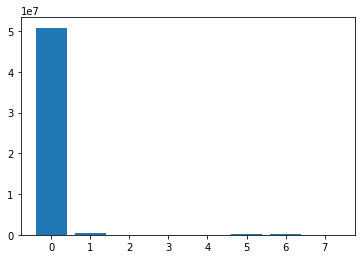

In [4]:
helper = ImageHelperFunctions()
list_img_paths = helper.list_files_in_dir(IMAGE_DIR, '.tif')
list_mask_paths = helper.list_files_in_dir(MASK_DIR, '.tif')

images = [np.array(helper.read_image(image)) for image in list_img_paths]
# mu, std = ImageHelperFunctions.find_mu_and_std(images)
# print(mu, std)

masks = [np.array(helper.read_image(mask)) for mask in list_mask_paths]
classes, counts = helper.count_classes_in_arr(masks, show=True)

# There shows a huge inbalance between the classes
# Class 0 is the background, so we remove it from the plot

# class_weights = [(sum(counts) / (c)) for c in counts]
# class_weights = torch.tensor(class_weights)
# print(class_weights)

class_weights = torch.FloatTensor(class_weights)
class_weights = class_weights.to(device)

# My solution was to just to manually put in some weights sort of like a hyper-parameter.
# I will be passing it as a parameter in the loss function.

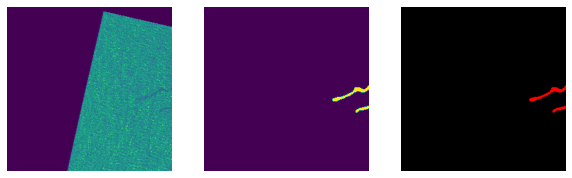

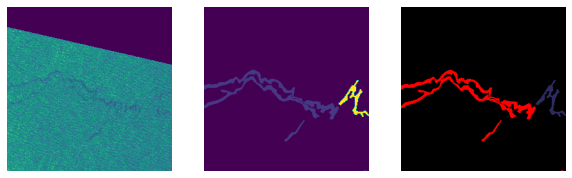

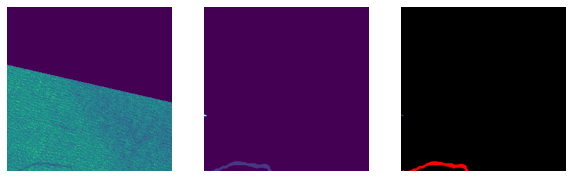

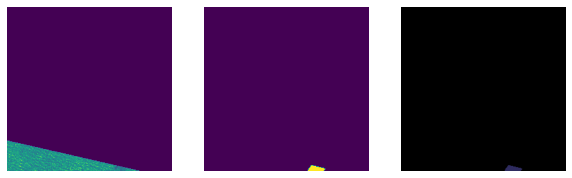

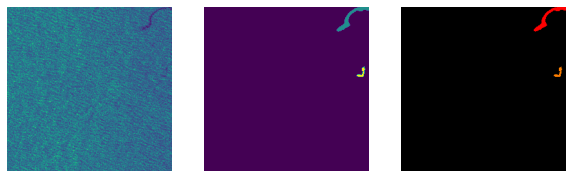

image type: <class 'numpy.ndarray'>
image shape: (256, 256)
image type: <class 'numpy.ndarray'>
image shape: (256, 256)


In [5]:
transform = ImageTransformFunctions()

for i in range(5):
    image = helper.read_image(list_img_paths[i])
    mask = helper.read_mask(list_mask_paths[i])
    mask_to_pal = transform.mask_to_palette(mask)
    helper.preview_images((image, mask, mask_to_pal))
    
helper.image_properties(image)
helper.image_properties(mask)

In [6]:
dataset = SeepImageDataset(IMAGE_DIR, MASK_DIR)
n_test = int(np.floor(0.1 * len(dataset)))
n_train = len(dataset) - n_test

train_ds, test_ds = random_split(dataset, [n_train, n_test])

In [7]:
train_loader = DataLoader(
    dataset = train_ds,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_loader = DataLoader(
    dataset = test_ds,
    batch_size = BATCH_SIZE,
    shuffle = True
)

x, y = next(iter(train_loader))
print(x[0], x.shape, y.shape)

mu, std = helper.find_mu_and_std(train_loader)
print(mu, std)

tensor([[[-0.3349, -0.3349, -0.3349,  ..., -0.3349, -0.3349, -0.3349],
         [-0.3349, -0.3349, -0.3349,  ..., -0.3349, -0.3349, -0.3349],
         [-0.3349, -0.3349, -0.3349,  ..., -0.3349, -0.3349, -0.3349],
         ...,
         [-0.3349, -0.3349, -0.3349,  ..., -0.3349, -0.3349, -0.3349],
         [-0.3349, -0.3349, -0.3349,  ..., -0.3349, -0.3349, -0.3349],
         [-0.3349, -0.3349, -0.3349,  ..., -0.3349, -0.3349, -0.3349]]]) torch.Size([8, 1, 256, 256]) torch.Size([8, 256, 256])
tensor([-0.0270]) tensor([1.0301])


<class 'torch.Tensor'> torch.Size([1, 256, 256])
-1.825607 1.1557494 0.5172494 0.3492024
(256, 256)
-----
<class 'torch.Tensor'> torch.Size([256, 256])
(256, 256)
0 6 0.5312281833755061 0.055999755859375


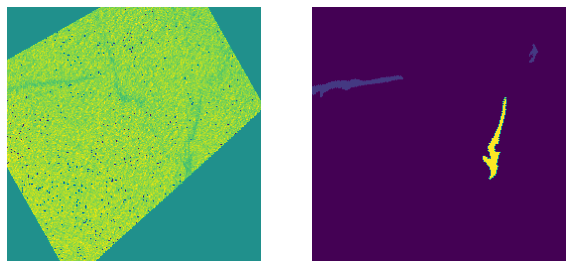

In [8]:
image, mask = next(iter(train_ds))

print(type(image), image.shape)
image = image.numpy()
print(image.min(), image.max(), image.std(), image.mean())
image = np.squeeze(image)
print(image.shape)
print('-----')

print(type(mask), mask.shape)
mask = mask.numpy()
print(mask.shape)
mask = np.squeeze(mask)
print(mask.min(), mask.max(), mask.std(), mask.mean())

helper.preview_images((image, mask))

# TRAINING

In [9]:
model = UNet(NUM_CHANNELS, NUM_CLASSES).to(device)

In [10]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [11]:
def train_overfit_single_batch(train_loader, model, loss_fn, opt, n_epochs=N_EPOCHS, lr=LR, patience=PATIENCE):
    x, y = next(iter(train_loader))
    for epoch in tqdm(range(n_epochs)):
        model.train()
        x = x.to(device)
        targets = y.to(device)
        
        preds = model(x)
        
        loss = loss_fn(preds, targets)
        print(f"epoch: {epoch}, loss: {loss.item()}")
        
        opt.zero_grad()
        loss.backward()
        
        opt.step()

In [12]:
def train(train_loader, val_loader, model, loss_fn, opt, n_epochs=N_EPOCHS, lr=LR, batch_size=BATCH_SIZE, patience=PATIENCE, fn=SUMMARY_WRITER_NAME, counter=0):
    writer = SummaryWriter(f"./runs/{fn}")

    best_val_loss = float("inf")
    
    total_steps = 0
    total_loss = 0
    total_val_loss = 0
    for epoch in tqdm(range(n_epochs)):
        model.train()
        for x, y in train_loader:
            x = x.to(device)
            targets = y.to(device)   
                   
            preds = model(x)
            
            loss = loss_fn(preds, targets)
            
            opt.zero_grad()
            loss.backward()
            
            opt.step()
            total_loss = total_loss + loss.item()
            
        total_steps += batch_size
        avg_train_loss = total_loss / len(train_loader)
        writer.add_scalar('train_loss', avg_train_loss, total_steps)
        print(f"epoch {epoch} loss {avg_train_loss}")
        
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                for x, y in val_loader:
                    x = x.to(device)
                    targets = y.to(device)
                    
                    preds = model(x)
                    
                    val_loss = loss_fn(preds, targets)
                    
                    total_val_loss = total_val_loss + val_loss.item()
            
            avg_val_loss = total_val_loss / len(val_loader)
            writer.add_scalar('val_loss', avg_val_loss, total_steps)
            print(f"epoch {epoch}, val_loss: {avg_val_loss}")
            
            if avg_val_loss <= best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), f"./models/{fn}")
            else:
                counter = counter + 1
                if counter >= patience:
                    break
                    
        total_loss = 0
        total_val_loss = 0
                
    writer.close()

In [13]:
if TRAIN:
   # loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    loss_fn = FocalLoss(weight=class_weights)
    opt = optim.Adam(model.parameters(), lr=LR)
    
    train_overfit_single_batch(train_loader, model, loss_fn, opt, n_epochs=20, lr=LR, patience=PATIENCE)
    train(train_loader, test_loader, model, loss_fn, opt)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0, loss: 1.6433237791061401
epoch: 1, loss: 1.177114486694336
epoch: 2, loss: 0.7770764827728271
epoch: 3, loss: 0.7185729742050171
epoch: 4, loss: 0.49140480160713196
epoch: 5, loss: 0.43901559710502625
epoch: 6, loss: 0.3559093475341797
epoch: 7, loss: 0.31635019183158875
epoch: 8, loss: 0.2860110402107239
epoch: 9, loss: 0.2720387279987335
epoch: 10, loss: 0.26405131816864014
epoch: 11, loss: 0.25760146975517273
epoch: 12, loss: 0.24931080639362335
epoch: 13, loss: 0.24352668225765228
epoch: 14, loss: 0.23882511258125305
epoch: 15, loss: 0.233808696269989
epoch: 16, loss: 0.2279828041791916
epoch: 17, loss: 0.22271251678466797
epoch: 18, loss: 0.21744143962860107
epoch: 19, loss: 0.21315987408161163


  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 